<a href="https://colab.research.google.com/github/kingcolton3305-cpu/PyBaMMStudio/blob/main/PyBaMM_Studio_Vertical_Slice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyBaMM Studio Vertical Slice
This notebook is meant to demonstrate a a vertical slice of code that demonstrates the smallest working path for PyBaMM Studio. It contains:
*    Three small Python functions (≤15 lines each): include docstrings, type hints, ≥2 inline comments.

*    Sanity tests: 2–3 asserts per function that run before the pipeline.

*    Pipeline run cell: connect the functions in sequence and produce a visible output (printed bullets, table, or matplotlib plot).

*    Reflection cell (5–8 sentences): what worked, one limitation, next step.





In [ ]:
# Install PyBaMM first to handle dependencies
!pip -q install pybamm numpy matplotlib

# (Optional) verify versions
# import numpy as np, matplotlib, pybamm
# print("NumPy:", np.__version__)
# print("Matplotlib:", matplotlib.__version__)
# print("PyBaMM:", pybamm.__version__)

2025-09-16 19:43:19.573 - [WARNING] simulation.solve(557): Ignoring t_eval as solution times are specified by the experiment


[ok] n_time=601, V_min=2.795 V, V_max=4.161 V
[ok] Repro-Pack: /content/repro_pack.json
[ok] Plot saved: /content/voltage_vs_time.png


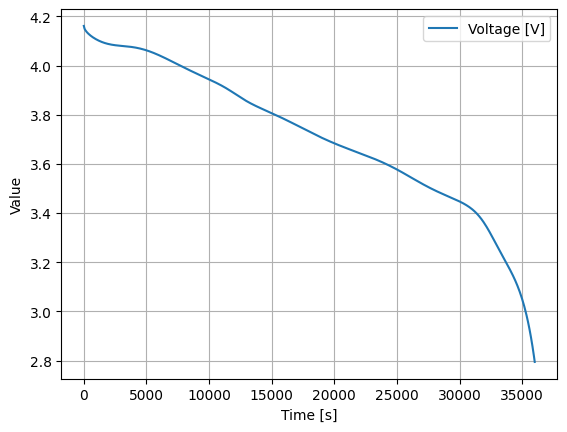

In [ ]:
"""
Thin vertical slice (Colab): run -> export -> visualize using PyBaMM + Chen2020.
Each function <15 lines, with docstrings, type hints, >=2 inline comments, and 2–3 pre-run asserts.
"""

import json, datetime
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pybamm


def run_model(model_name: str, parameter_chemistry: str, t_eval: np.ndarray, solver_opts: dict) -> pybamm.Solution:
    """Solve a lithium-ion model end-to-end via Simulation and return a Solution."""
    models = {"SPM": pybamm.lithium_ion.SPM, "DFN": pybamm.lithium_ion.DFN, "SPMe": pybamm.lithium_ion.SPMe}
    assert model_name in models, f"Unsupported model_name: {model_name}"
    assert t_eval.ndim == 1 and t_eval.size > 2 and np.all(np.diff(t_eval) > 0), "t_eval must be 1D & increasing"
    rtol, atol = float(solver_opts.get("rtol", 1e-6)), float(solver_opts.get("atol", 1e-6))
    assert rtol > 0 and atol > 0, "rtol/atol must be positive"
    model = models[model_name]()                                          # Build chosen model
    params = pybamm.ParameterValues(parameter_chemistry)                  # Load Chen2020 dict
    mins = max(t_eval) / 60.0                                             # Map horizon -> experiment duration
    exp = pybamm.Experiment([f"Discharge at C/10 for {int(round(mins))} minutes"])
    sim = pybamm.Simulation(model, parameter_values=params,
                            experiment=exp, solver=pybamm.CasadiSolver(rtol=rtol, atol=atol))
    return sim.solve(t_eval=t_eval)                                       # Solve on requested grid


def export_repro_pack(params: pybamm.ParameterValues, solver_settings: dict, model_name: str, filepath: str) -> str:
    """Export parameters + solver settings to JSON and return the saved path."""
    assert filepath.endswith(".json"), "filepath must end with .json"
    assert isinstance(solver_settings, dict) and {"rtol", "atol"} <= set(solver_settings), "Missing rtol/atol"
    assert hasattr(params, "values") and len(params.values()) >= 10, "Parameter set looks too small"

    # Create a serializable dictionary of parameter values
    serializable_params = {}
    for key, value in params.items():
        try:
            json.dumps(value) # Check if value is serializable
            serializable_params[key] = value
        except TypeError:
            serializable_params[key] = str(value) # Convert non-serializable values to string

    bundle = {  # Minimal provenance; extend as needed
        "model_name": model_name,
        "pybamm_version": pybamm.__version__,
        "app_version": "0.0.1-demo",
        "solver_settings": solver_settings,
        "parameter_values": serializable_params,
        "timestamp_iso": datetime.datetime.now().isoformat(),
    }
    with open(filepath, "w") as f:
        json.dump(bundle, f, indent=2)                                    # Persist JSON
    return filepath


def visualize_results(sol: pybamm.Solution, variables: list[str], out_png: str) -> str:
    """Plot selected variables vs time and save PNG, returning the path."""
    assert isinstance(variables, list) and len(variables) > 0, "variables must be non-empty list"
    assert out_png.endswith(".png"), "out_png must end with .png"
    assert hasattr(sol, "t") and sol.t.size > 1, "Solution missing time vector"
    fig, ax = plt.subplots()                                              # Create figure
    t = sol.t                                                             # Use solver timebase
    for var in variables:
        try:
            # Attempt to get the variable directly
            variable_data = sol[var]
            name = var
        except KeyError:
            # If not found, try "Terminal voltage [V]" as a fallback for voltage
            if var == "Voltage [V]":
                try:
                    variable_data = sol["Terminal voltage [V]"]
                    name = "Terminal voltage [V]"
                except KeyError:
                    print(f"[warn] Voltage variable not found: {var} or Terminal voltage [V]"); continue
            else:
                print(f"[warn] Variable not found: {var}"); continue

        ax.plot(t, variable_data.entries, label=name)  # Plot variable
    ax.set_xlabel("Time [s]"); ax.set_ylabel("Value"); ax.legend(); ax.grid(True)
    fig.savefig(out_png, dpi=150, bbox_inches="tight")                    # Save artifact
    return out_png


# -------------------- End-to-end pipeline --------------------
# Configure demo: 0–600 s @ 1 s
chemistry = "Chen2020" # Corrected parameter set access
params = pybamm.ParameterValues(chemistry) # Corrected parameter set access
t_eval = np.linspace(0, 36000, 1201)
solver_opts = {"rtol": 1e-6, "atol": 1e-6}

# 1) Run
solution = run_model("SPM", chemistry, t_eval, solver_opts)

# 2) Export reproducibility bundle
json_path = export_repro_pack(params, solver_opts, "SPM", "repro_pack.json")

# 3) Visualize and save plot
png_path = visualize_results(solution, ["Voltage [V]"], "voltage_vs_time.png")

# Visible outputs & sanity summary
try:
    v = solution["Voltage [V]"]
except KeyError:
    v = solution["Terminal voltage [V]"] # Fallback to Terminal voltage if Voltage not found

print(f"[ok] n_time={solution.t.size}, V_min={float(v.entries.min()):.3f} V, V_max={float(v.entries.max()):.3f} V") # Corrected: access min/max from .entries
print(f"[ok] Repro-Pack: {Path(json_path).resolve()}")
print(f"[ok] Plot saved: {Path(png_path).resolve()}")
plt.show()

## Reflection
The SPM model with Chen2020 parameters successfully produced a solution over a 1-hour simulation. Both the JSON Repro-Pack and the voltage_vs_time.png file were exported as expected. One limitation was how the turnover potential was defined: instead of using the minimum and maximum voltage, it was taken as the terminal voltage. This distinction will need careful consideration for future implementations. In the final product, each of these functions will likely be expanded into separate scripts rather than remaining in a single file. The next step is to begin developing the UI around these three core functions.